In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk
from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer
from nltk.stem import SnowballStemmer
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
import string
import re
import warnings as wr


wr.filterwarnings("ignore")


In [2]:
data=pd.read_csv(r'../input/sms-spam-collection-dataset/spam.csv',encoding="ISO-8859-1")
x=data.copy()

In [3]:
x.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [4]:
missingValues=x.isna().sum()/x.shape[0]
print(f'Missing Values Ratio : \n{missingValues}')

Missing Values Ratio : 
v1            0.000000
v2            0.000000
Unnamed: 2    0.991027
Unnamed: 3    0.997846
Unnamed: 4    0.998923
dtype: float64


<AxesSubplot:xlabel='v1', ylabel='count'>

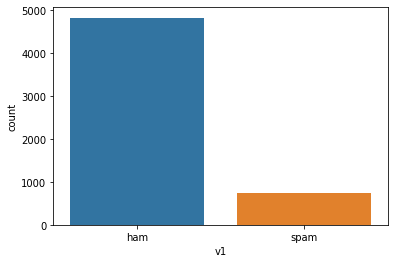

In [5]:
sns.countplot(x["v1"])

Data isn't balanced

In [6]:
mapping={'ham':0,'spam':1}
x['v1']=x['v1'].replace(mapping)

In [7]:
x=x.fillna(' ')
x['concat']=x['v2']+x['Unnamed: 2']+x['Unnamed: 3']+x['Unnamed: 4']

In [8]:
x.drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4','v2'],axis=1,inplace=True)
x.rename(columns={'v1':'classifier','concat':'texts'},inplace=True)

In [9]:
x['texts'] = x['texts'].str.lower()
x['#tokens'],x['#char'],x['#sentences'],x['#stopwords'],x['#tokensAfter'],x['#numbersinTxt'],x['#uniqueWords'],x['Mails&phones'],x['#len_steem']=0,0,0,0,0,0,0,0,0
x['pureText']=x['texts']

In [10]:
def lemmaOrStem(tokens,stemm=False,stemmer='',lemma=False,partOfSpeech=''):

    if (stemm):
        if(stemmer=='Porter'):
            porter = PorterStemmer()
            porterStemming = [porter.stem(j)  for j in tokens]
            return porterStemming

        #---------landstremmer------#    
        elif(stemmer=='lancaster'):    
        
            lancaster=LancasterStemmer()
            lancasterStemming = [lancaster.stem(j)  for j in tokens]
            return lancasterStemming
            
    #---------------SnowballStemmer--------#

        elif(stemmer=='snow') :
                sm = SnowballStemmer("english")
                snowballStemming = [sm.stem(j)  for j in tokens]
                return snowballStemming
   
    if(lemma):        
    #----------Lemmatization---------#
        lemm = nltk.WordNetLemmatizer()
        #ADJ, ADJ_SAT, ADV, NOUN, VERB = 'a', 's', 'r', 'n', 'v'
        lemm_1 = [lemm.lemmatize(j,pos=partOfSpeech) for j in tokens]
        return lemm_1
   


In [11]:
def mail_phone(text):
    mail=re.findall(r"\S{0,}\@[a-z]{0,}\.[a-z]{1,4}",text)
    phone=re.findall(r"[\+]?[0-9]{2}\s*[0-9]{6,9}",text)
    return mail,phone

In [12]:

stop = set(stopwords.words('english'))

for i in range(0,x.shape[0]):
    
    x['#char'][i]=len(x['texts'][i])
    
    tokens = word_tokenize(x['texts'][i])
    x['#tokens'][i]= len(tokens)
    
    sentences=nltk.sent_tokenize(x['texts'][i])
    if(len(sentences)==1 or len(sentences)==0):
        x['#sentences'][i] =0
    else : x['#sentences'][i] =1   
    
    
    tokensOfpureTextWithoutstop=[token for token in x['texts'][i].split() if token not in stop]
    x['pureText'][i] = " ".join(tokensOfpureTextWithoutstop)
    
    textWithoutPunctuations= re.findall(r'\w+',x['pureText'][i])
    x['pureText'][i] = " ".join(textWithoutPunctuations)
    
    counNum=re.findall(r'\d+',x['pureText'][i])
    x['#numbersinTxt'][i]=len(counNum)
    
    x['#uniqueWords'][i]=len(set(textWithoutPunctuations))

    x['#tokensAfter'][i]= len(textWithoutPunctuations)
    
    x['#stopwords'][i]=(x['#tokens'][i])-(len(tokensOfpureTextWithoutstop))
    
    mail,phone=mail_phone(x['pureText'][i])
    x['Mails&phones'][i]=len(mail)+len(phone)
    
    lemmaText=lemmaOrStem(x['texts'][i].split(),stemm=False,stemmer='',lemma=True,partOfSpeech='n')
    x['#len_steem'][i]=len(lemmaText)

In [13]:
x.head()

,classifier,texts,#tokens,#char,#sentences,#stopwords,#tokensAfter,#numbersinTxt,#uniqueWords,Mails&phones,#len_steem,pureText
0,0,"go until jurong point, crazy.. available only ...",23,114,0,7,16,0,16,0,20,go jurong point crazy available bugis n great ...
1,0,ok lar... joking wif u oni...,8,32,0,2,6,0,6,0,6,ok lar joking wif u oni
2,1,free entry in 2 a wkly comp to win fa cup fina...,36,158,0,13,28,6,25,1,28,free entry 2 wkly comp win fa cup final tkts 2...
3,0,u dun say so early hor... u c already then say...,13,52,0,4,9,0,7,0,11,u dun say early hor u c already say
4,0,"nah i don't think he goes to usf, he lives aro...",15,64,0,8,7,0,7,0,13,nah think goes usf lives around though


In [14]:
x.drop(['texts'],axis=1,inplace=True)

<AxesSubplot:>

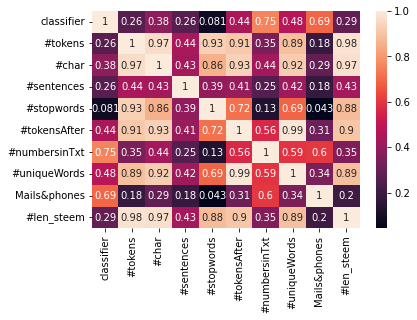

In [15]:
corr = x.iloc[:,0:-1].corr()
sns.heatmap(corr,annot=corr)

In [16]:
x.drop(['#stopwords'],axis=1,inplace=True)

**Works on Feature we extract**

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB


lr=LogisticRegression(max_iter=10000)

lr.fit(x.iloc[:,1:-1],x.iloc[:,0])
print(lr.score(x.iloc[:,1:-1],x.iloc[:,0]))

nb=MultinomialNB()
nb.fit(x.iloc[:,1:-1],x.iloc[:,0])
print(nb.score(x.iloc[:,1:-1],x.iloc[:,0]))

svm=SVC()
svm.fit(x.iloc[:,1:-1],x.iloc[:,0])
print(svm.score(x.iloc[:,1:-1],x.iloc[:,0]))


0.966618808327351
0.9558506819813353
0.951543431442929
